In [13]:
import sys
import pdb
import time
# sys.path.append("C:\\users\\mccar\\miniconda3\\lib\\site-packages")
sys.path.append("C:\\Python310\\Lib\\site-packages")
from bettermdptools.algorithms.planner import Planner
from bettermdptools.utils.plots import Plots
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from bettermdptools.utils.blackjack_wrapper import BlackjackWrapper
from bettermdptools.utils.test_env import TestEnv
from bettermdptools.algorithms.rl import RL
from bettermdptools.utils.decorators import add_to
import numpy as np
import seaborn as sns


In [14]:
env = gym.make("Blackjack-v1")

In [15]:
from bettermdptools.utils.blackjack_wrapper import BlackjackWrapper

base_env = gym.make('Blackjack-v1', render_mode=None)
blackjack = BlackjackWrapper(base_env)
blackjack.P

In [16]:
# run VI
V, V_track, pi = Planner(blackjack.P).value_iteration(gamma=0.9)
# print(V_track)

#test policy
# test_scores = TestEnv.test_env(env=blackjack, n_iters=100, render=False, pi=pi, user_input=False)
# print(np.mean(test_scores))

runtime = 0.07 seconds


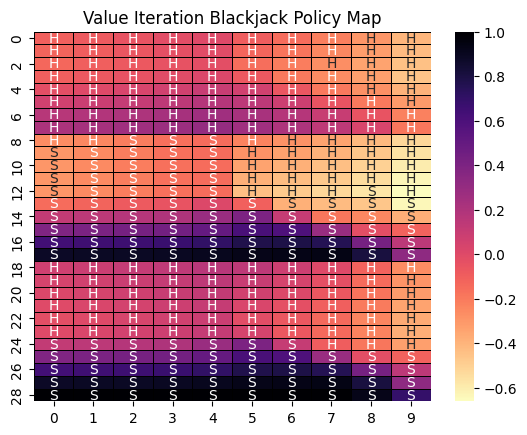

In [17]:
#create actions dictionary and set map size
blackjack_actions = {0: "S", 1: "H"}
blackjack_map_size=(29, 10)

#get formatted state values and policy map
val_max, policy_map = Plots.get_policy_map(pi, V, blackjack_actions, blackjack_map_size)

# #plot policy map
# title="Unedited\nBlackjack Policy Map"
# Plots.plot_policy(val_max, policy_map, blackjack_map_size, title)

@add_to(Plots)
@staticmethod
def modified_plot_policy(val_max, directions, map_size, title):
    """Plot the policy learned."""
    sns.heatmap(
        val_max,
        annot=directions,
        fmt="",
        cmap=sns.color_palette("magma_r", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
    ).set(title=title)
    img_title = f"Policy_{map_size[0]}x{map_size[1]}.png"
    plt.show()

title = "Value Iteration Blackjack Policy Map"
Plots.modified_plot_policy(val_max, policy_map, blackjack_map_size, title)

In [18]:
# Value Iteration Blackjack Policy Map
gamma_vals = [0.9, 0.95, 0.99]

def value_iteration(env, epsilon=1e-1, num_iterations=1):
    """
    Value iteration algorithm for the given environment.
    """
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    
    rewards_per_iteration_list = []
    deltas_per_iteration_list = []
    times_per_iteration_list = []
    Vs = []
    
    for gamma_val in gamma_vals:
        rewards_gamma = []
        deltas_gamma = []
        times_gamma = []
        
        for _ in range(num_iterations):
            # Initialize the value function
            this_iter = 0
            V = np.zeros(num_states)
            
            rewards_per_iteration = []
            deltas_per_iteration = []
            times_per_iteration = []
            
            while True:
                delta = 0
                start_time = time.time()  # Start time for the current iteration
                
                for s in range(num_states):
                    v_orig = V[s]
                    # Update the value function using Bellman optimality equation
                    Q_s = np.zeros(num_actions)
                    for a in range(num_actions):
                        for prob, next_state, reward, _ in env.P[s][a]:
                            Q_s[a] += prob * (reward + gamma_val * V[next_state])
                    V[s] = np.max(Q_s)
                    delta = max(delta, abs(v_orig - V[s]))
                
                end_time = time.time()  # End time for the current iteration
                iteration_time = end_time - start_time  # Time taken for the current iteration
                
                rewards_per_iteration.append(np.mean(V))  # Average reward for the current iteration
                deltas_per_iteration.append(delta)  # Delta for the current iteration
                times_per_iteration.append(iteration_time)  # Time for the current iteration
                
                this_iter += 1
                if delta < epsilon or np.array_equal(v_orig, V):
                    print(f"Converged for gamma = {gamma_val} after {this_iter} iterations")
                    print(f"Time taken: {time.time() - start_time}")
                    break
            
            rewards_gamma.append(rewards_per_iteration)
            deltas_gamma.append(deltas_per_iteration)
            times_gamma.append(times_per_iteration)
            Vs.append(V)
        
        rewards_per_iteration_list.append(rewards_gamma)
        deltas_per_iteration_list.append(deltas_gamma)
        times_per_iteration_list.append(times_gamma)
    
    results_dict = {
        'rewards': rewards_per_iteration_list,
        'deltas': deltas_per_iteration_list,
        'times': times_per_iteration_list,
        'V': Vs
    }
    # total time in seconds
    print(f"Total time taken: ", time.time() - start_time)
    return results_dict

results_dict = value_iteration(blackjack)

Converged for gamma = 0.9 after 20 iterations
Time taken: 0.0010290145874023438
Converged for gamma = 0.95 after 39 iterations
Time taken: 0.0
Converged for gamma = 0.99 after 194 iterations
Time taken: 0.01825690269470215
Total time taken:  0.01825690269470215


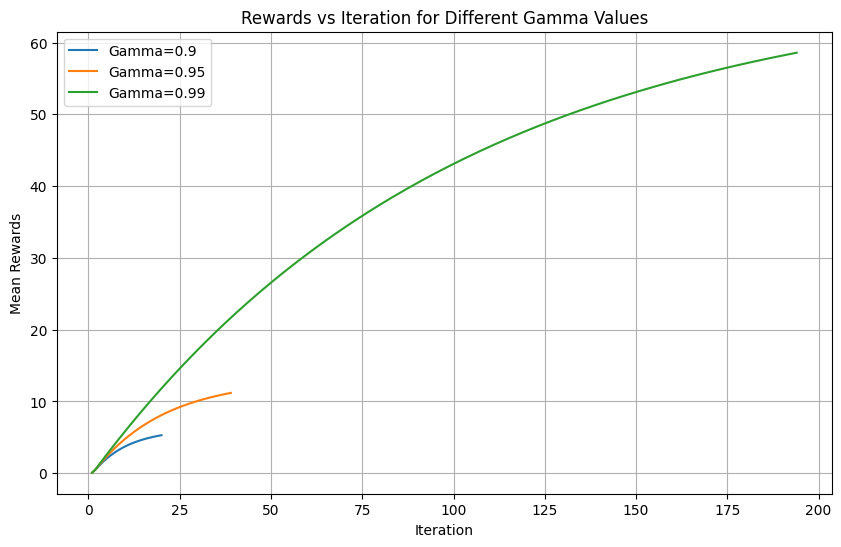

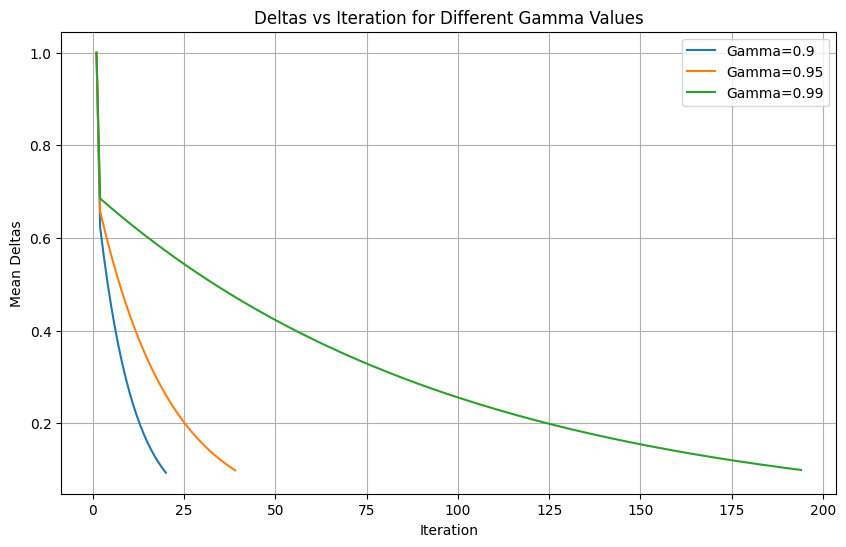

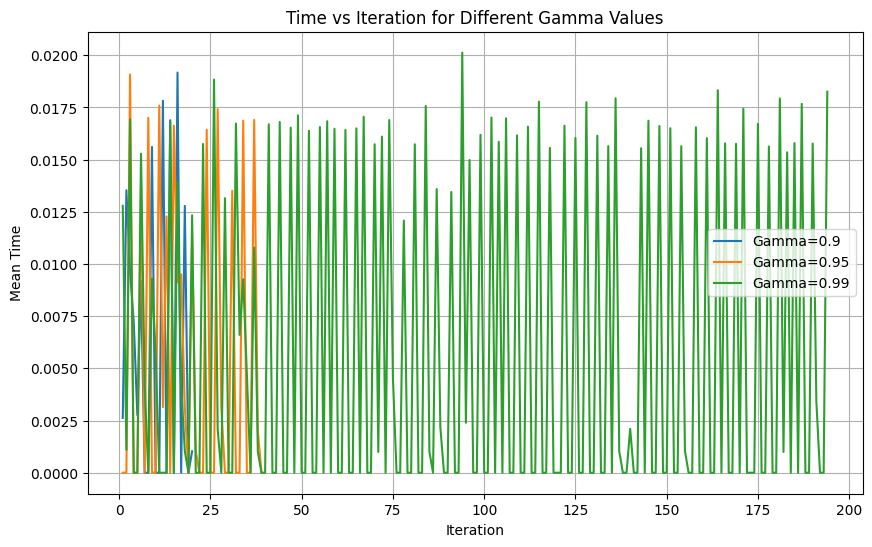

In [19]:
# Value iteration plot
# Extract rewards data for each gamma value
rewards_data = results_dict['rewards']
deltas_data = results_dict['deltas']
times_data = results_dict['times']
# print(rewards_data[0][2])

# Plotting
plt.figure(figsize=(10, 6))
for i, gamma_val in enumerate(gamma_vals):
    iterations = range(1, len(rewards_data[i][0]) + 1)
    mean_rewards = np.mean(rewards_data[i], axis=0)
    std_rewards = np.std(rewards_data[i], axis=0) 
    plt.plot(iterations, mean_rewards, label=f'Gamma={gamma_val}')
    plt.fill_between(iterations, mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.3)

plt.title('Rewards vs Iteration for Different Gamma Values')
plt.xlabel('Iteration')
plt.ylabel('Mean Rewards')
plt.legend()
plt.grid(True)
plt.show()


# plot delta graph
plt.figure(figsize=(10, 6))
for i, gamma_val in enumerate(gamma_vals):
    iterations = range(1, len(deltas_data[i][0]) + 1)
    mean_deltas = np.mean(deltas_data[i], axis=0)
    std_deltas = np.std(deltas_data[i], axis=0) 
    plt.plot(iterations, mean_deltas, label=f'Gamma={gamma_val}')
    plt.fill_between(iterations, mean_deltas - std_deltas, mean_deltas + std_deltas, alpha=0.3)

plt.title('Deltas vs Iteration for Different Gamma Values')
plt.xlabel('Iteration')
plt.ylabel('Mean Deltas')
plt.legend()
plt.grid(True)
plt.show()


# plot time graph
plt.figure(figsize=(10, 6))
for i, gamma_val in enumerate(gamma_vals):
    iterations = range(1, len(times_data[i][0]) + 1)
    mean_times = np.mean(times_data[i], axis=0)
    std_times = np.std(times_data[i], axis=0) 
    plt.plot(iterations, mean_times, label=f'Gamma={gamma_val}')
    plt.fill_between(iterations, mean_times - std_times, mean_times + std_times, alpha=0.3)

plt.title('Time vs Iteration for Different Gamma Values')
plt.xlabel('Iteration')
plt.ylabel('Mean Time')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
# Policy plot

for iter, gamma_val in enumerate(gamma_vals):
    V = results_dict['V'][iter]
    val_max, policy_map = Plots.get_policy_map(pi, V, blackjack_actions, blackjack_map_size)
    title = f"Value Iteration Blackjack Policy Map, Gamma={gamma_val}"
    Plots.modified_plot_policy(val_max, policy_map, blackjack_map_size, title)
    

NameError: name 'gamma_vals' is not defined

In [21]:
# Policy Iteration
def policy_iteration(env, gamma=1.0, n_iters=50, theta=1e-10):
        """
        PARAMETERS:

        gamma {float}:
            Discount factor

        n_iters {int}:
            Number of iterations

        theta {float}:
            Convergence criterion for policy evaluation.
            State values are considered to be converged when the maximum difference between new and previous state
            values is less than theta.


        RETURNS:

        V {numpy array}, shape(possible states):
            State values array

        V_track {numpy array}, shape(n_episodes, nS):
            Log of V(s) for each iteration

        pi {lambda}, input state value, output action value:
            Policy mapping states to actions.
        """
        rewards_per_iteration = []
        delta_track = []
        runtime_per_iteration = []
        random_actions = np.random.choice(tuple(env.P[0].keys()), len(env.P))

        pi = {s: a for s, a in enumerate(random_actions)}
        # initial V to give to `policy_evaluation` for the first time
        V = np.zeros(len(env.P), dtype=np.float64)
        V_track = np.zeros((n_iters, len(env.P)), dtype=np.float64)
        i = 0
        converged = False
        while i < n_iters-1 and not converged:
            start_time = time.time()
            i += 1
            old_pi = pi
            V, delta = policy_evaluation(env, pi, V, gamma, theta)
            V_track[i] = V
            pi = policy_improvement(env, V, gamma)
            rewards_per_iteration.append(np.mean(V))
            delta_track.append(delta)
            end_time = time.time()
            runtime_per_iteration.append(end_time - start_time)
            if old_pi == pi:
                converged = True
        return V, V_track, pi, rewards_per_iteration, delta_track, runtime_per_iteration

def policy_evaluation(env, pi, prev_V, gamma=1.0, theta=1e-10):
    while True:
        V = np.zeros(len(env.P), dtype=np.float64)
        for s in range(len(env.P)):
            for prob, next_state, reward, done in env.P[s][pi[s]]:
                V[s] += prob * (reward + gamma * prev_V[next_state] * (not done))
        delta = np.max(np.abs(prev_V - V))
        if np.max(np.abs(prev_V - V)) < theta:
            break
        prev_V = V.copy()
    return V, delta

def policy_improvement(env, V, gamma=1.0):
    Q = np.zeros((len(env.P), len(env.P[0])), dtype=np.float64)
    for s in range(len(env.P)):
        for a in range(len(env.P[s])):
            for prob, next_state, reward, done in env.P[s][a]:
                Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))

    new_pi = {s: a for s, a in enumerate(np.argmax(Q, axis=1))}
    return new_pi


# Run policy iteration for different gammas
results_dict = {}
gammas = [0.9, 0.95, 0.99]
for gamma in gammas:
    print(f"Running policy iteration for gamma={gamma}...")
    V, V_track, pi, rewards_per_iteration, delta_track, runtime_per_iteration = policy_iteration(blackjack, gamma=gamma)
    results_dict[gamma] = {
        'V': V,
        'V_track': V_track,
        'pi': pi,
        'rewards': rewards_per_iteration,
        'delta': delta_track,
        'times': runtime_per_iteration
    }
    print(f"Optimal Policy for gamma={gamma}:")
    print(pi)
    print(f"Average Reward per Iteration for gamma={gamma}:")
    print(rewards_per_iteration)
    print(f"Delta per Iteration for gamma={gamma}:")
    print(delta_track)
    print(f"Runtime per Iteration for gamma={gamma}: {runtime_per_iteration} seconds")
    print()

Running policy iteration for gamma=0.9...
Optimal Policy for gamma=0.9:
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 0, 83: 0, 84: 0, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 1, 126: 1, 127: 1, 128: 0, 129: 

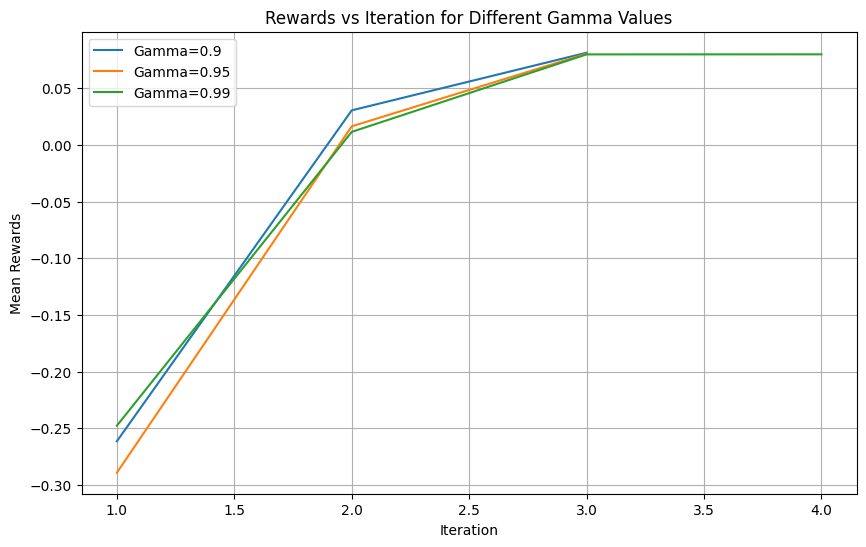

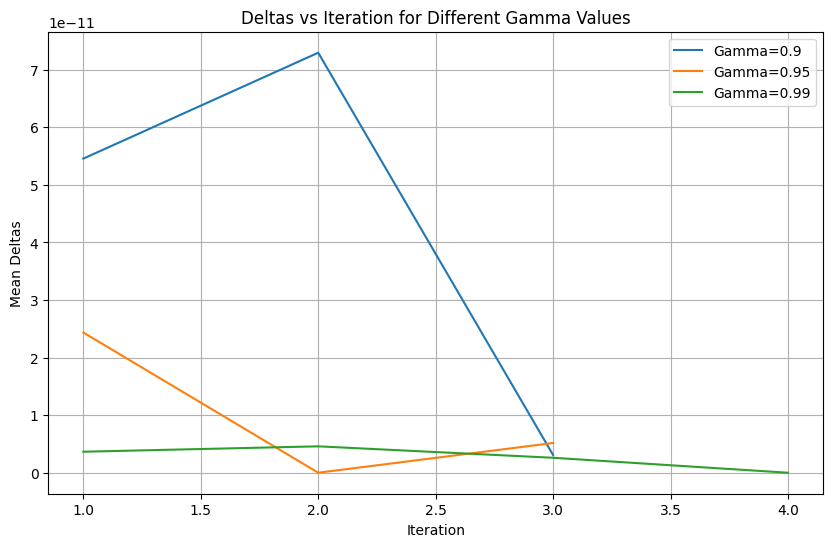

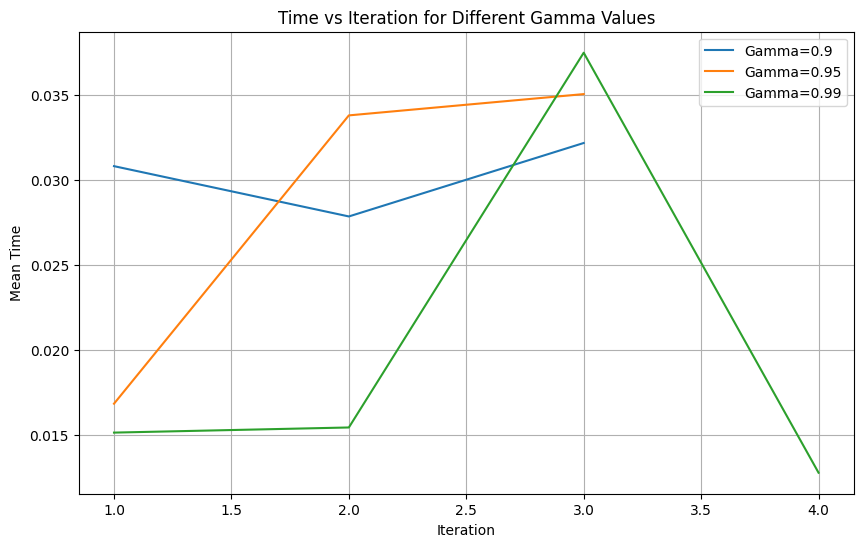

In [22]:
# Policy Iteration Plotting
plt.figure(figsize=(10, 6))
for i, gamma_val in enumerate(gamma_vals):
    iterations = range(1, len(results_dict[gamma_val]['rewards']) + 1)
    mean_rewards = results_dict[gamma_val]['rewards']
    plt.plot(iterations, mean_rewards, label=f'Gamma={gamma_val}')
plt.title('Rewards vs Iteration for Different Gamma Values')
plt.xlabel('Iteration')
plt.ylabel('Mean Rewards')
plt.legend()
plt.grid(True)
plt.show()

# plot delta graph
plt.figure(figsize=(10, 6))
for i, gamma_val in enumerate(gamma_vals):
    iterations = range(1, len(results_dict[gamma_val]['delta']) + 1)
    mean_deltas = results_dict[gamma_val]['delta']
    plt.plot(iterations, mean_deltas, label=f'Gamma={gamma_val}')
plt.title('Deltas vs Iteration for Different Gamma Values')
plt.xlabel('Iteration')
plt.ylabel('Mean Deltas')
plt.legend()
plt.grid(True)
plt.show()


# plot time graph
plt.figure(figsize=(10, 6))
for i, gamma_val in enumerate(gamma_vals):
    iterations = range(1, len(results_dict[gamma_val]['times']) + 1)
    mean_times = results_dict[gamma_val]['times']
    plt.plot(iterations, mean_times, label=f'Gamma={gamma_val}')
plt.title('Time vs Iteration for Different Gamma Values')
plt.xlabel('Iteration')
plt.ylabel('Mean Time')
plt.legend()
plt.grid(True)
plt.show()

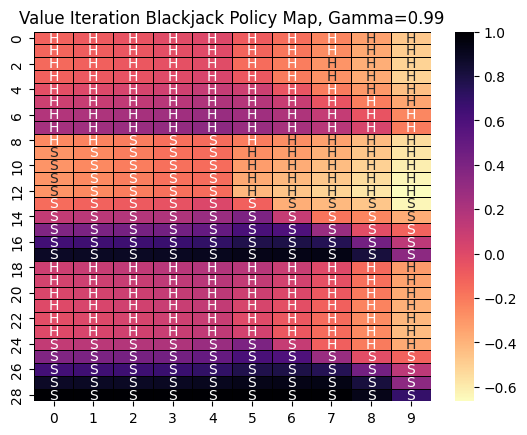

In [23]:
# print(V)
val_max, policy_map = Plots.get_policy_map(pi, V, blackjack_actions, blackjack_map_size)
title = f"Value Iteration Blackjack Policy Map, Gamma={gamma_val}"
Plots.modified_plot_policy(val_max, policy_map, blackjack_map_size, title)

In [45]:
# Q-Learning

# Define parameters
alpha = 0.1  # learning rate
gamma = 0.99  # discount factor
# epsilon = 0.1  # exploration rate

# Define helper functions
def epsilon_greedy_policy(state, Q, epsilon=0.1):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Explore action space
    else:
        return np.argmax(Q[state])

# Q-learning algorithm
def q_learning(env, num_episodes, epsilon=0.1):
    # Initialize Q-table
    Q = np.zeros((len(blackjack.P), len(blackjack.P[0])), dtype=np.float64)
    steps_per_run = []
    reward_per_run = []
    times_per_run = []
    for _ in range(num_episodes):
        start_time = time.time()
        state = env.reset()[0]
        done = False
        steps = 0
        total_reward = 0
        while not done:
            action = epsilon_greedy_policy(state, Q, epsilon)
            next_state, reward, done, trunc, _ = env.step(action)
            # Update Q-table
            old_q_value = Q[state][action]
            next_action = np.argmax(Q[next_state])
            Q[state][action] = old_q_value + alpha * (reward + gamma * Q[next_state][next_action] - old_q_value)
            state = next_state
            steps += 1
            total_reward += reward
        steps_per_run.append(steps)
        reward_per_run.append(total_reward)
        end_time = time.time()
        times_per_run.append(end_time - start_time)
    return steps_per_run, reward_per_run, times_per_run, Q

# Train the agent and collect data for multiple trials
num_trials = 10
num_episodes = 3000

epsilons = [0.01, 0.1, 0.2]
all_steps = []
all_rewards = []
all_times = []

for epsilon in epsilons:
    trials_steps = []
    trials_rewards = []
    trials_times = []
    for trial in range(num_trials):
        print(f"Running trial {trial + 1} with epsilon {epsilon}...")
        steps, rewards, times, Q = q_learning(blackjack, num_episodes, epsilon)
        trials_steps.append(steps)
        trials_rewards.append(rewards)
        trials_times.append(times)
    
    all_steps.append(trials_steps)
    all_rewards.append(trials_rewards)
    all_times.append(trials_times)

Running trial 1 with epsilon 0.01...
Running trial 2 with epsilon 0.01...
Running trial 3 with epsilon 0.01...
Running trial 4 with epsilon 0.01...
Running trial 5 with epsilon 0.01...
Running trial 6 with epsilon 0.01...
Running trial 7 with epsilon 0.01...
Running trial 8 with epsilon 0.01...
Running trial 9 with epsilon 0.01...
Running trial 10 with epsilon 0.01...
Running trial 1 with epsilon 0.1...
Running trial 2 with epsilon 0.1...
Running trial 3 with epsilon 0.1...
Running trial 4 with epsilon 0.1...
Running trial 5 with epsilon 0.1...
Running trial 6 with epsilon 0.1...
Running trial 7 with epsilon 0.1...
Running trial 8 with epsilon 0.1...
Running trial 9 with epsilon 0.1...
Running trial 10 with epsilon 0.1...
Running trial 1 with epsilon 0.2...
Running trial 2 with epsilon 0.2...
Running trial 3 with epsilon 0.2...
Running trial 4 with epsilon 0.2...
Running trial 5 with epsilon 0.2...
Running trial 6 with epsilon 0.2...
Running trial 7 with epsilon 0.2...
Running trial 8 

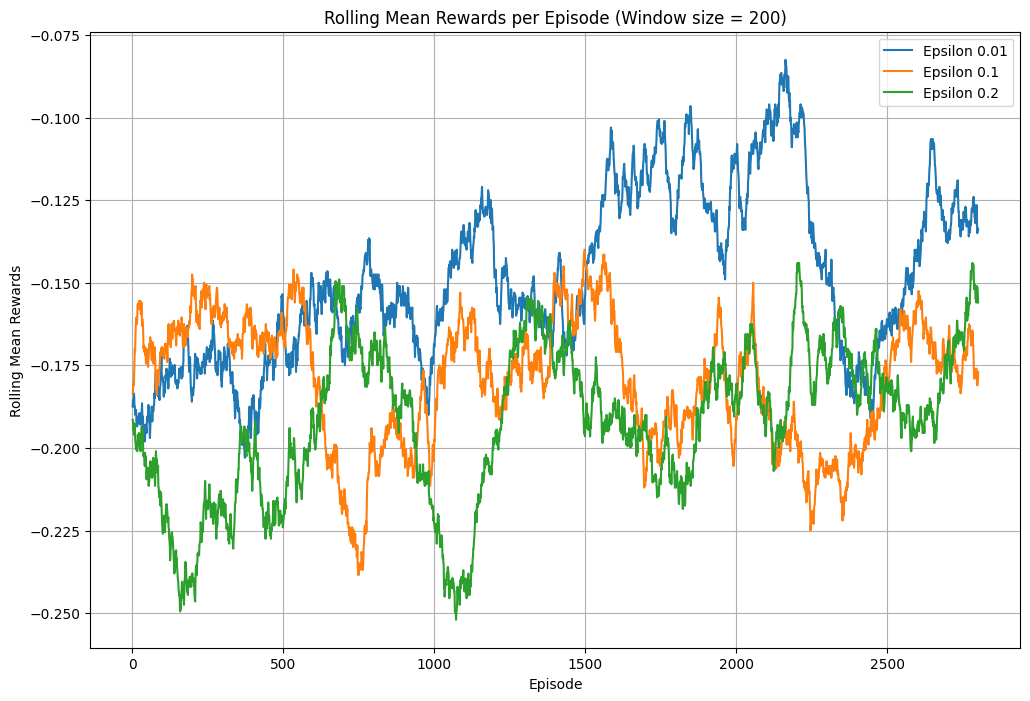

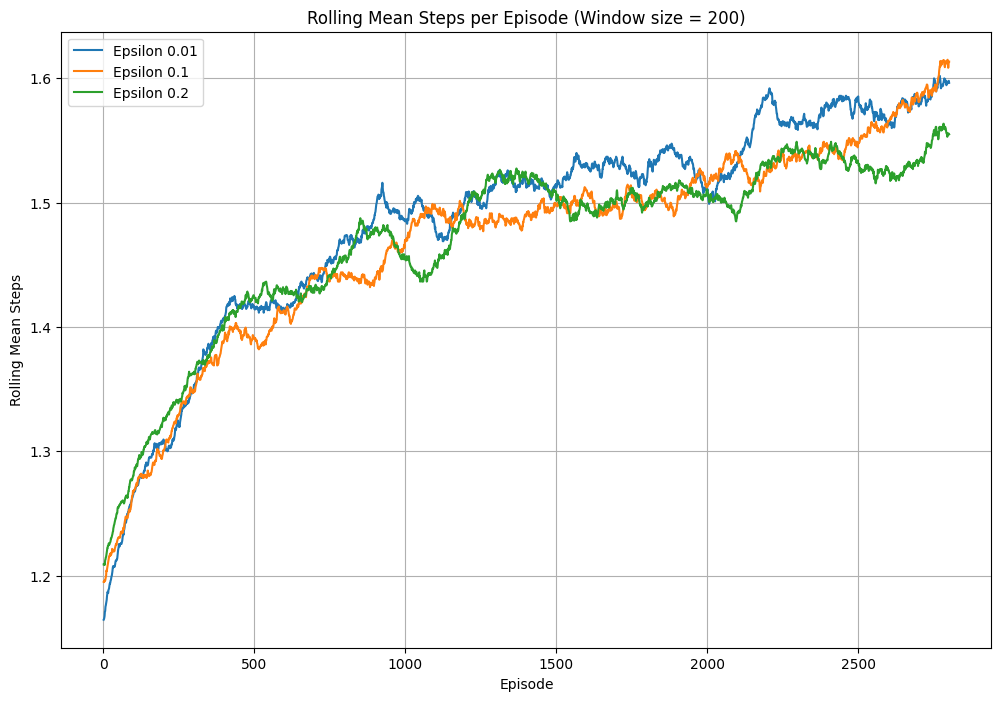

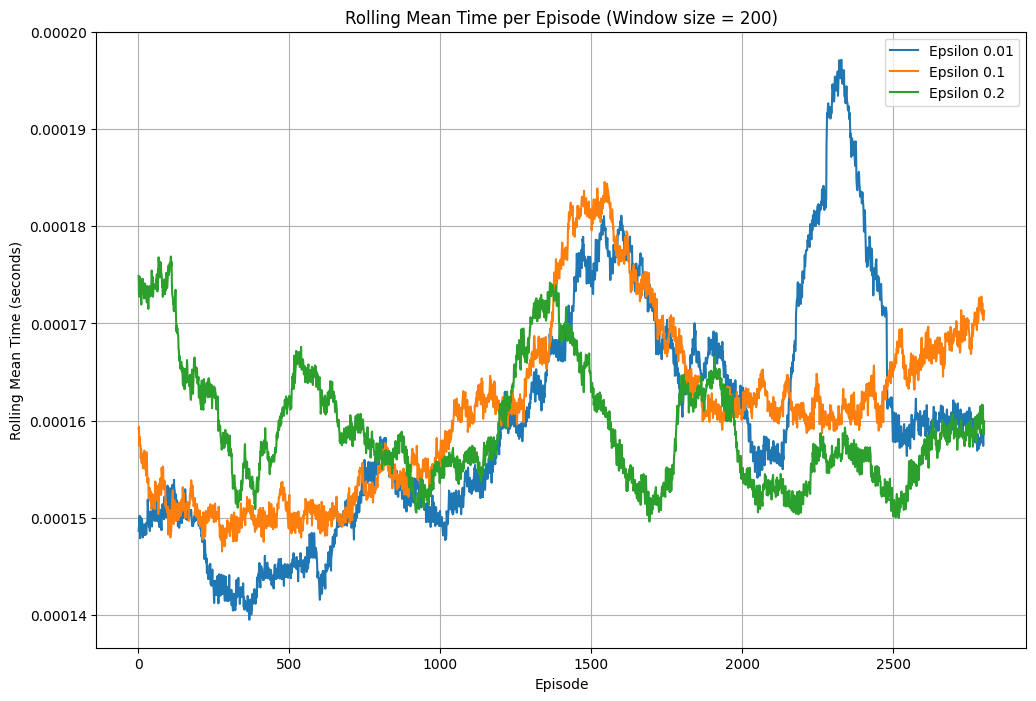

In [46]:
# Calculate rolling mean and standard deviation for each epsilon
rolling_window = 200
plt.figure(figsize=(12, 8))
for i, epsilon in enumerate(epsilons):
    all_rewards_rolling_mean = np.mean(np.array(all_rewards[i]), axis=0)
    all_rewards_rolling_mean = np.convolve(all_rewards_rolling_mean, np.ones(rolling_window)/rolling_window, mode='valid')
    # all_rewards_rolling_std = np.std(np.array(all_rewards[i]), axis=0)
    # all_rewards_rolling_std = np.sqrt(np.convolve(all_rewards_rolling_std**2, np.ones(rolling_window)/rolling_window, mode='valid'))
    plt.plot(range(1, len(all_rewards_rolling_mean) + 1), all_rewards_rolling_mean, label=f'Epsilon {epsilon}')
    # plt.fill_between(range(1, len(all_rewards_rolling_mean) + 1), all_rewards_rolling_mean - all_rewards_rolling_std, all_rewards_rolling_mean + all_rewards_rolling_std, alpha=0.2)

plt.xlabel('Episode')
plt.ylabel('Rolling Mean Rewards')
plt.title(f'Rolling Mean Rewards per Episode (Window size = {rolling_window})')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
for i, epsilon in enumerate(epsilons):
    all_steps_rolling_mean = np.mean(np.array(all_steps[i]), axis=0)
    all_steps_rolling_mean = np.convolve(all_steps_rolling_mean, np.ones(rolling_window)/rolling_window, mode='valid')
    # all_steps_rolling_std = np.std(np.array(all_steps[i]), axis=0)
    # all_steps_rolling_std = np.sqrt(np.convolve(all_steps_rolling_std**2, np.ones(rolling_window)/rolling_window, mode='valid'))
    plt.plot(range(1, len(all_steps_rolling_mean) + 1), all_steps_rolling_mean, label=f'Epsilon {epsilon}')
    # plt.fill_between(range(1, len(all_steps_rolling_mean) + 1), all_steps_rolling_mean - all_steps_rolling_std, all_steps_rolling_mean + all_steps_rolling_std, alpha=0.2)

plt.xlabel('Episode')
plt.ylabel('Rolling Mean Steps')
plt.title(f'Rolling Mean Steps per Episode (Window size = {rolling_window})')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
for i, epsilon in enumerate(epsilons):
    all_times_rolling_mean = np.mean(np.array(all_times[i]), axis=0)
    all_times_rolling_mean = np.convolve(all_times_rolling_mean, np.ones(rolling_window)/rolling_window, mode='valid')
    # all_times_rolling_std = np.std(np.array(all_times[i]), axis=0)
    # all_times_rolling_std = np.sqrt(np.convolve(all_times_rolling_std**2, np.ones(rolling_window)/rolling_window, mode='valid'))
    plt.plot(range(1, len(all_times_rolling_mean) + 1), all_times_rolling_mean, label=f'Epsilon {epsilon}')
    # plt.fill_between(range(1, len(all_times_rolling_mean) + 1), all_times_rolling_mean - all_times_rolling_std, all_times_rolling_mean + all_times_rolling_std, alpha=0.2)

plt.xlabel('Episode')
plt.ylabel('Rolling Mean Time (seconds)')
plt.title(f'Rolling Mean Time per Episode (Window size = {rolling_window})')
plt.legend()
plt.grid(True)
plt.show()

[[-1.00099900e-01  1.42361554e-01]
 [-1.00000000e-01  1.78511907e-01]
 [-1.00000000e-01  1.28512098e-01]
 [-1.00000000e-01  6.94948275e-02]
 [-1.00000000e-04  1.52127875e-01]
 [-1.00000000e-01  6.21299088e-03]
 [-1.00000000e-04  1.99488871e-01]
 [-1.00000000e-04  0.00000000e+00]
 [-1.00000000e-01  2.95136317e+00]
 [-1.00000000e-01 -8.92113302e-02]
 [-1.00000000e-01  7.68237167e-02]
 [-1.00000000e-01  6.61734578e-02]
 [-1.00000000e-01  4.53613264e-02]
 [-1.00000000e-01  4.76321382e-02]
 [-1.00000000e-01  2.60505413e-01]
 [-1.00000000e-01  7.99674009e-01]
 [-1.00000000e-01  1.61101199e-01]
 [-1.00000000e-01  2.52042464e-01]
 [-1.00000000e-04  3.91894020e+00]
 [-1.00000000e-01 -1.50059977e-01]
 [-1.00000000e-04  1.29204035e-01]
 [-1.00000000e-01  3.76358106e-01]
 [-1.00199600e-01  6.61891273e-01]
 [-1.00000000e-01  1.95371961e-01]
 [-1.00000000e-01  2.18739356e-01]
 [-1.99900000e-01 -1.51340541e-03]
 [-1.00099900e-01  3.79233306e-01]
 [-1.00000000e-01  1.18218959e-01]
 [-1.00597206e-01  4

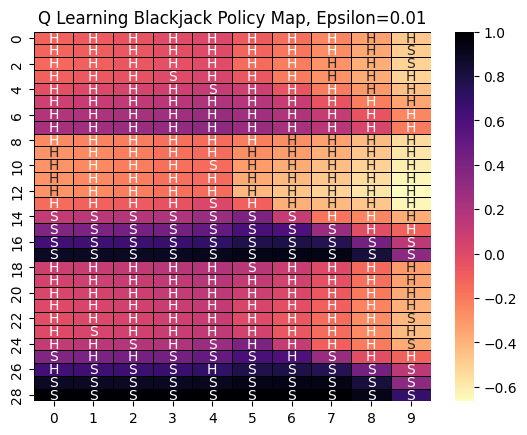

In [48]:
steps, rewards, times, Q = q_learning(blackjack, 10000, 0.01)
print(Q)
print(Q.shape)
new_pi = {s: a for s, a in enumerate(np.argmax(Q, axis=1))}

# print(V)
val_max, policy_map = Plots.get_policy_map(new_pi, V, blackjack_actions, blackjack_map_size)
title = f"Q Learning Blackjack Policy Map, Epsilon=0.01"
Plots.modified_plot_policy(val_max, policy_map, blackjack_map_size, title)